In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud")

# Biblioteke

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
from scipy.stats import norm
import imblearn
import sklearn

from sklearn import svm

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score


# Globalne varijable

In [ ]:
RFC_METRIC = 'gini'  #metrika za RandomForrestClassifier
NUM_ESTIMATORS = 100 #broj estimatora koristenih za RandomForrestClassifier
NO_JOBS = 4 #broj paralelnih radnji za RandomForrestClassifier
RANDOM_STATE = 2022

Učitavanje dataset-a

In [ ]:
dataset = pd.read_csv("/content/creditcardfraud/creditcard.csv")

# Vizualizacija podataka

Distribucija podataka

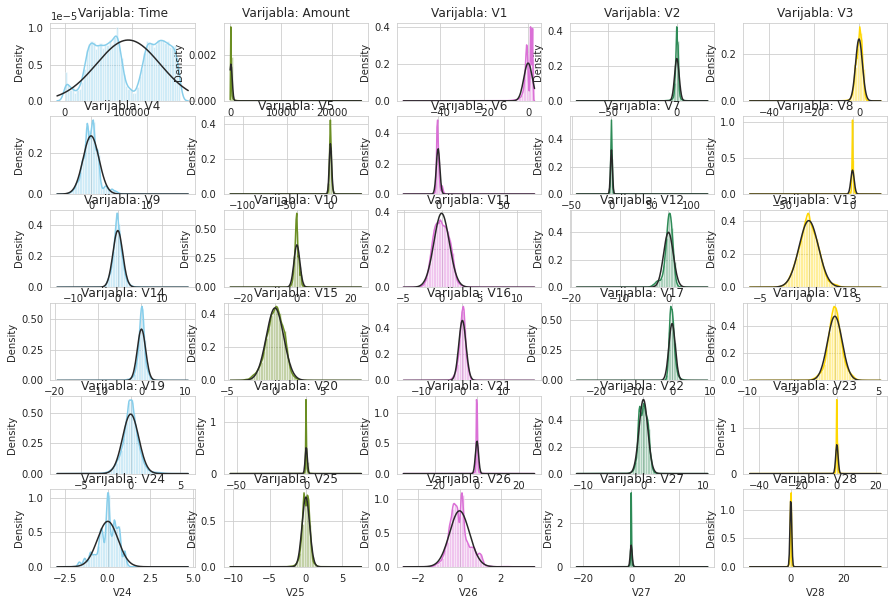

<Figure size 432x288 with 0 Axes>

In [ ]:
variables = ["Time", "Amount", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11",
             "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24",
             "V25", "V26", "V27", "V28"]

colors = ["skyblue", "olivedrab", "orchid", "seagreen", "gold"]

f, axes = plt.subplots(6, 5, figsize=(15, 10))
sns.set_style("whitegrid")
k = 0
for i in range(6):
    for j in range(5):
        sns.distplot(dataset[variables[k]], ax=axes[i,j], fit=norm, color=colors[j%5])
        axes[i,j].set_title("Varijabla: " + variables[k])
        k = k + 1

plt.subplots_adjust(hspace = 0.8)
plt.show()

Raspon vrijednosti - boxplotovi

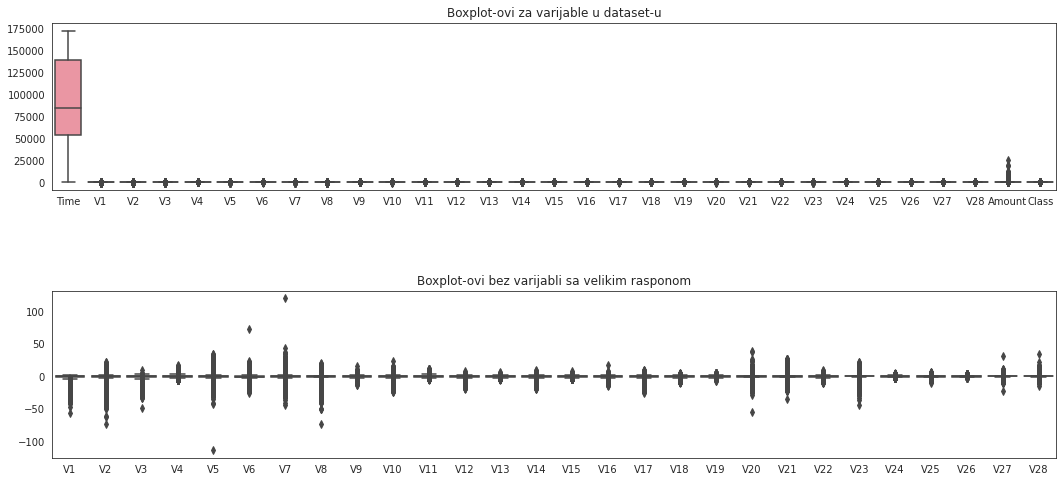

In [ ]:
f, axes = plt.subplots(2,1, figsize=(18, 8))

modified_dataset = dataset.drop(['Class', 'Amount', 'Time'], axis=1)

sns.boxplot(data=dataset, ax=axes[0])
axes[0].set_title("Boxplot-ovi za varijable u dataset-u", fontsize=12)
sns.boxplot(data=modified_dataset, ax=axes[1])
axes[1].set_title("Boxplot-ovi bez varijabli sa velikim rasponom", fontsize=12)

plt.subplots_adjust(hspace = 0.6)
plt.show()

Prikaz nebalansiranosti

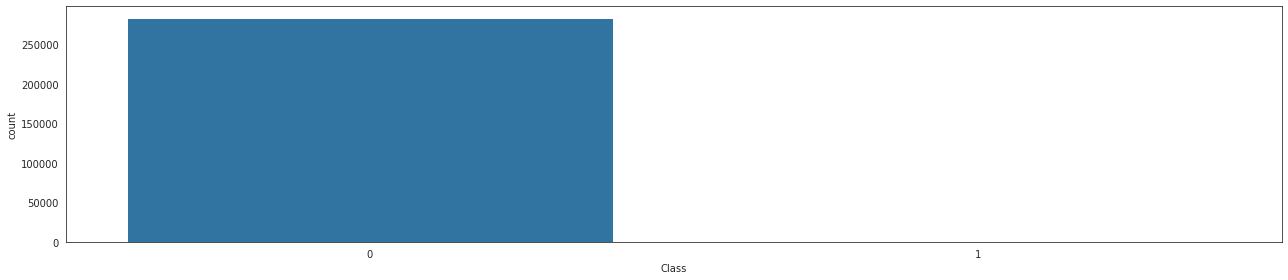

In [ ]:
sns.set_style("white")
f, axes = plt.subplots(figsize=(18, 4))
axes=sns.countplot(x="Class", data=dataset)
plt.tight_layout()

# Predprocesiranje podataka

1. Uklanjanje outlier-a



In [ ]:
dataset = dataset[dataset.Amount<=6000]
dataset = dataset[dataset.V1>=-31]
dataset = dataset[dataset.V2>=-27]
dataset = dataset[dataset.V3<=5]
dataset = dataset[dataset.V4>=-5]
dataset = dataset[dataset.V5>=-23]
dataset = dataset[dataset.V5<=20]
dataset = dataset[dataset.V6<=12]
dataset = dataset[dataset.V6>=-10]
dataset = dataset[dataset.V7<=20]
dataset = dataset[dataset.V8>=-50]
dataset = dataset[dataset.V9<=10]
dataset = dataset[dataset.V10<=15]
dataset = dataset[dataset.V13<=4]
dataset = dataset[dataset.V15<=4]
dataset = dataset[dataset.V17<=8]
dataset = dataset[dataset.V19>=-4.5]
dataset = dataset[dataset.V20<=12.5]
dataset = dataset[dataset.V20>=-16]
dataset = dataset[dataset.V23<=15]
dataset = dataset[dataset.V23>=-20]
dataset = dataset[dataset.V24<=2.5]
dataset = dataset[dataset.V25<=4]
dataset = dataset[dataset.V25>=-5]
dataset = dataset[dataset.V26>=-1.8]
dataset = dataset[dataset.V26<=3.3]
dataset = dataset[dataset.V27<=6.5]
dataset = dataset[dataset.V27>=-9]
dataset = dataset[dataset.V28<=4]
dataset = dataset[dataset.V28>=-6.5]

2. Log space transformacija nad V1 i Amount koje imaju *skewed* distribuciju




In [ ]:
skewed_features = ["V1", "Amount"]
pt = PowerTransformer()
dataset[skewed_features] = pt.fit_transform(dataset[skewed_features])

3. Prije balansiranja i normalizacije, biti ce uradjena podjela na test, train, val

In [ ]:
train_ratio = 0.60
validation_ratio = 0.15
test_ratio = 0.25

train_data, test_data = train_test_split(dataset, train_size = train_ratio, random_state = 77)

val_data, test_data = train_test_split(test_data, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 0) 

4. Skaliranje podataka sa robust scalerom

In [ ]:
features_to_scale = ["Time", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15",
                     "V16","V17","V18", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28", "Amount"]

In [ ]:
st = StandardScaler()

train_data[features_to_scale] = st.fit_transform(train_data[features_to_scale])
test_data[features_to_scale] = st.transform(test_data[features_to_scale])
val_data[features_to_scale] = st.transform(val_data[features_to_scale])

5. Balansiranje dataset-a

***SMOTE***

In [ ]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy=0.6, random_state=0)
train_smote_data, train_smote_data['Class'] = smote.fit_resample(train_data, train_data['Class'])

In [ ]:
train_smote_data["Class"].value_counts()

0    170310
1    102186
Name: Class, dtype: int64

**SMOTE + RUC**

In [ ]:
smote2 = imblearn.over_sampling.SMOTE(sampling_strategy=0.5, random_state=1)
smote_ruc_dataset, smote_ruc_dataset['Class'] = smote2.fit_resample(train_data, train_data['Class'])

ruc = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1.0, random_state=0)
train_smote_ruc_data, train_smote_ruc_data['Class'] = ruc.fit_resample(smote_ruc_dataset, smote_ruc_dataset['Class'])

In [ ]:
train_smote_ruc_data["Class"].value_counts()

0    85155
1    85155
Name: Class, dtype: int64

# Neuronska mreža

### Config

In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.0 MB/s eta 0:00:00


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner
from tensorflow.keras.layers import BatchNormalization

In [ ]:
!nvidia-smi

Fri Jan 20 12:21:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Definisanje metrika

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

### Plotanje

In [ ]:
def show_loss(history):
    plt.figure(figsize=(9,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Gubitak (loss)')
    plt.ylabel('Gubitak (loss)')
    plt.xlabel('Epoha')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [ ]:
def show_acc(history):
    plt.figure(figsize=(9,6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Tačnost (accuracy)')
    plt.ylabel('Tačnost (accuracy)')
    plt.xlabel('Epoha')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [ ]:
def show_recall(history):
    plt.figure(figsize=(9,6))
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoha')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [ ]:
def show_precision(history):
    plt.figure(figsize=(9,6))
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoha')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(9,6))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [ ]:
def plot_roc(name, labels, predictions):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

### Early Stopping

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

In [ ]:
#Za hyperband
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',  mode='min', patience=5, verbose=1,min_delta=0.001, restore_best_weights=True)

### Definisanje modela

In [ ]:
def build_model(hp):
  model = keras.Sequential()
  model.add(layers.Input(shape=(30,)))

  model.add(layers.Dense(
                units=hp.Int("units1", min_value=32, max_value=512, step=32),   #trazimo optimalni broj neurona u ovom dense sloju
                activation=hp.Choice('dense_activation1', values=['relu', 'tanh', 'elu', 'selu'], default='relu')))   #trazimo optimalnu aktivacijsku funkciju
  model.add(layers.Dropout(hp.Float("dropout1", 0, 0.8, step=0.1, default=0.5)))    #trazimo optimalni dropout

  model.add(layers.Dense(
                units=hp.Int("units2", min_value=32, max_value=512, step=32),   #trazimo optimalni broj neurona u ovom dense sloju
                activation=hp.Choice('dense_activation2', values=['relu', 'tanh', 'elu', 'selu'], default='relu')))   #trazimo optimalnu aktivacijsku funkciju
  model.add(layers.Dropout(hp.Float("dropout2", 0, 0.8, step=0.1, default=0.5)))    #trazimo optimalni dropout

  model.add(layers.Dense(
                units=hp.Int("units3", min_value=32, max_value=512, step=32),   #trazimo optimalni broj neurona u ovom dense sloju
                activation=hp.Choice('dense_activation3', values=['relu', 'tanh', 'elu', 'selu'], default='relu')))   #trazimo optimalnu aktivacijsku funkciju
  model.add(layers.Dropout(hp.Float("dropout3", 0, 0.8, step=0.1, default=0.5)))    #trazimo optimalni dropout
  

  model.add(layers.Dense(
                units=hp.Int("units4", min_value=32, max_value=512, step=32),   
                activation=hp.Choice('dense_activation4', values=['relu', 'tanh', 'elu', 'selu'], default='relu'))) 
  model.add(layers.Dropout(hp.Float("dropout4", 0, 0.8, step=0.1, default=0.5))) 

  model.add(layers.Dense(
                units=hp.Int("units5", min_value=32, max_value=512, step=32),
                activation=hp.Choice('dense_activation5', values=['relu', 'tanh', 'elu', 'selu'], default='relu')))
  
  model.add(layers.Dense(
                units=hp.Int("units6", min_value=32, max_value=512, step=32),
                activation=hp.Choice('dense_activation6', values=['relu', 'tanh', 'elu', 'selu'], default='relu')))

  model.add(layers.Dense(1, activation="sigmoid"))
  
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6]) #podesavanje stope ucenja
  optimizer = hp.Choice("optimizer", ["adam", "adamax", "rmsprop", "adadelta", "sgd"]) #podesavanje optimizatora
    
  if optimizer == 'rmsprop':
      optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
  elif optimizer == 'adam':
      optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
  elif optimizer == 'adamax':
      optimizer = keras.optimizers.Adamax(learning_rate=hp_learning_rate)
  elif optimizer == 'adadelta':
      optimizer = keras.optimizers.Adamax(learning_rate=hp_learning_rate)
  elif optimizer == 'sgd':
      optimizer = keras.optimizers.Adamax(learning_rate=hp_learning_rate)
  else:
      raise
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=METRICS)

  return model

build_model(keras_tuner.HyperParameters())



### Oversamplirani dataset

#### Izdvajanje feature-a i labela

In [ ]:
#Za smote dataset
x_train_smote = train_smote_data.drop('Class', axis=1)
y_train_smote = train_smote_data['Class']

x_test = test_data.drop('Class', axis=1)
y_test = test_data['Class']

x_val = val_data.drop('Class', axis=1)
y_val = val_data['Class']

#### Izdvajanje malog skupa radi tuniranja hiperparametara

In [ ]:
#Za smote dataset
x_smote_train_tiny = x_train_smote[:3000]
y_smote_train_tiny = y_train_smote[:3000]

x_smote_val_tiny = x_val[:2500]
y_smote_val_tiny = y_val[:2500]

In [ ]:
print(np.bincount(y_smote_val_tiny))

[2496    4]


#### Pronalazak najboljih hiperparametara

In [ ]:
tuner = keras_tuner.Hyperband(
                     hypermodel=build_model,
                     objective='val_loss',
                     max_epochs=30,
                     factor=3,
                     directory="smote",
                     project_name="smote",
                     overwrite = True)

tuner.search(x_smote_train_tiny, y_smote_train_tiny, epochs=50,  callbacks=[stop_early], 
             validation_data=(x_smote_val_tiny, y_smote_val_tiny))
tuner.search_space_summary()  #sazetak konfiguracije

Trial 90 Complete [00h 00m 44s]
val_loss: 0.5068560242652893

Best val_loss So Far: 0.006487375590950251
Total elapsed time: 00h 14m 27s
Search space summary
Default search space size: 18
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu'], 'ordered': False}
dropout1 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.1, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu'], 'ordered': False}
dropout2 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.1, 'sampling': None}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32

In [ ]:
#Najbolji hiperparametri:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("Dropout1: ", best_hps.get('dropout1'))
print("Learning rate1: ", best_hps.get('learning_rate'))
print("Units1: ", best_hps.get('units1'))
print("Dense activation1: ", best_hps.get('dense_activation1'))

print("Units2: ", best_hps.get('units2'))
print("Dense activation2: ", best_hps.get('dense_activation2'))
print("Dropout2: ", best_hps.get('dropout2'))
print("Learning rate2: ", best_hps.get('learning_rate'))

print("Units3: ", best_hps.get('units3'))
print("Dense activation3: ", best_hps.get('dense_activation3'))
print("Dropout3: ", best_hps.get('dropout3'))
print("Learning rate3: ", best_hps.get('learning_rate'))

print("Units4: ", best_hps.get('units4'))
print("Dense activation4: ", best_hps.get('dense_activation4'))
print("Dropout4: ", best_hps.get('dropout4'))
print("Learning rate4: ", best_hps.get('learning_rate'))

print("Units5: ", best_hps.get('units5'))
print("Dense activation5: ", best_hps.get('dense_activation5'))
print("Learning rate5: ", best_hps.get('learning_rate'))

print("Optimizator: ", best_hps.get('optimizer'))

Dropout1:  0.4
Learning rate1:  0.0001
Units1:  416
Dense activation1:  tanh
Units2:  160
Dense activation2:  relu
Dropout2:  0.5
Learning rate2:  0.0001
Units3:  256
Dense activation3:  tanh
Dropout3:  0.2
Learning rate3:  0.0001
Units4:  64
Dense activation4:  tanh
Dropout4:  0.0
Learning rate4:  0.0001
Units5:  352
Dense activation5:  elu
Learning rate5:  0.0001
Optimizator:  adam


#### Treniranje nad citavim skupom x_train_smote, y_train_smote

In [ ]:

# Dohvati najbolje hiperparametre
best_hps = tuner.get_best_hyperparameters(5)

# Kreiraj model sa tim parametrima
smote_model = build_model(best_hps[0])

#Treniranje nad citavim skupom
fitted_model2 = smote_model.fit(x_train_smote, y_train_smote, epochs=100, validation_data=(x_val, y_val), 
                                callbacks=early_stopping, batch_size = 128, validation_batch_size=128)

Epoch 1/100
2129/2129 [==============================] - 18s 7ms/step - loss: 0.0930 - tp: 96192.0000 - fp: 4520.0000 - tn: 168286.0000 - fn: 5998.0000 - accuracy: 0.9618 - precision: 0.9551 - recall: 0.9413 - auc: 0.9935 - val_loss: 0.0390 - val_tp: 62.0000 - val_fp: 789.0000 - val_tn: 41790.0000 - val_fn: 9.0000 - val_accuracy: 0.9813 - val_precision: 0.0729 - val_recall: 0.8732 - val_auc: 0.9447
Epoch 2/100
2129/2129 [==============================] - 15s 7ms/step - loss: 0.0369 - tp: 100655.0000 - fp: 2338.0000 - tn: 167972.0000 - fn: 1531.0000 - accuracy: 0.9858 - precision: 0.9773 - recall: 0.9850 - auc: 0.9989 - val_loss: 0.0228 - val_tp: 60.0000 - val_fp: 374.0000 - val_tn: 42205.0000 - val_fn: 11.0000 - val_accuracy: 0.9910 - val_precision: 0.1382 - val_recall: 0.8451 - val_auc: 0.9473
Epoch 3/100
2129/2129 [==============================] - 15s 7ms/step - loss: 0.0237 - tp: 101369.0000 - fp: 1519.0000 - tn: 168791.0000 - fn: 817.0000 - accuracy: 0.9914 - precision: 0.9852 - r

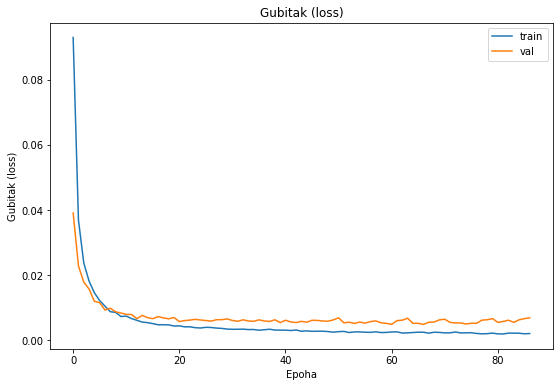

In [ ]:
show_loss(fitted_model2)

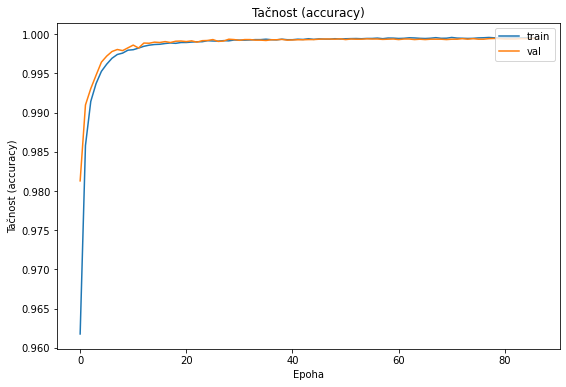

In [ ]:
show_acc(fitted_model2)

#### Testiranje modela

In [ ]:
#TEST
eval_result = smote_model.evaluate(x_test, y_test)
print("[loss tp fp tn fn accuracy precision recall auc auc-roc]:", eval_result)

2222/2222 [==============================] - 11s 5ms/step - loss: 0.0045 - tp: 112.0000 - fp: 26.0000 - tn: 70927.0000 - fn: 19.0000 - accuracy: 0.9994 - precision: 0.8116 - recall: 0.8550 - auc: 0.9388
[loss tp fp tn fn accuracy precision recall auc auc-roc]: [0.004489912185817957, 112.0, 26.0, 70927.0, 19.0, 0.9993669390678406, 0.8115941882133484, 0.8549618124961853, 0.9387764930725098]


556/556 [==============================] - 1s 2ms/step


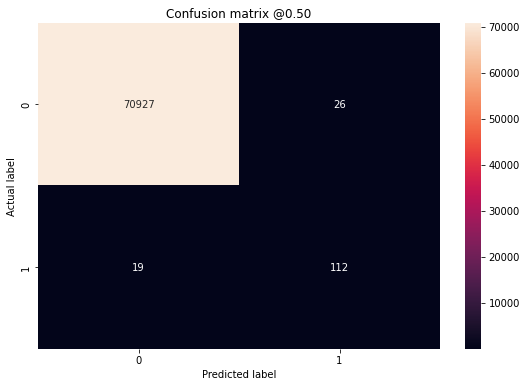

In [ ]:
train_predictions = smote_model.predict(x_train_smote, batch_size=128)
test_predictions = smote_model.predict(x_test, batch_size=128)
plot_cm(y_test, test_predictions)

### RUC + oversamplirani dataset

#### Izdvajanje feature-a i labela

In [ ]:
#Za smote + ruc
x_train_smote_ruc = train_smote_ruc_data.drop('Class', axis=1)
y_train_smote_ruc = train_smote_ruc_data['Class']

#### Izdavajanje malog skupa radi tuniranja hiperparametara

In [ ]:
#Za smote dataset
x_smote_ruc_train_tiny = x_train_smote_ruc[:2000]
y_smote_ruc_train_tiny = y_train_smote_ruc[:2000]

x_smote_ruc_val_tiny = x_val[:2000]
y_smote_ruc_val_tiny = y_val[:2000]

#### Tuniranje

In [ ]:
tuner2 = keras_tuner.Hyperband(
                     hypermodel=build_model,
                     objective='val_loss',
                     max_epochs=25,
                     factor=3,
                     directory="smote",
                     project_name="smote",
                     overwrite = True)

tuner2.search(x_smote_train_tiny, y_smote_train_tiny, epochs=50,  callbacks=[stop_early], 
             validation_data=(x_smote_val_tiny, y_smote_val_tiny))
tuner2.search_space_summary()  #sazetak konfiguracije

Trial 30 Complete [00h 00m 12s]
val_loss: 0.013927340507507324

Best val_loss So Far: 0.006667254026979208
Total elapsed time: 00h 06m 09s
Search space summary
Default search space size: 18
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu'], 'ordered': False}
dropout1 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.1, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu'], 'ordered': False}
dropout2 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.1, 'sampling': None}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 

In [ ]:
#Najbolji hiperparametri:
best_hps=tuner2.get_best_hyperparameters(num_trials=1)[0]
print("Dropout1: ", best_hps.get('dropout1'))
print("Learning rate1: ", best_hps.get('learning_rate'))
print("Units1: ", best_hps.get('units1'))
print("Dense activation1: ", best_hps.get('dense_activation1'))

print("Units2: ", best_hps.get('units2'))
print("Dense activation2: ", best_hps.get('dense_activation2'))
print("Dropout2: ", best_hps.get('dropout2'))
print("Learning rate2: ", best_hps.get('learning_rate'))

print("Units3: ", best_hps.get('units3'))
print("Dense activation3: ", best_hps.get('dense_activation3'))
print("Dropout3: ", best_hps.get('dropout3'))
print("Learning rate3: ", best_hps.get('learning_rate'))

print("Units4: ", best_hps.get('units4'))
print("Dense activation4: ", best_hps.get('dense_activation4'))
print("Dropout4: ", best_hps.get('dropout4'))
print("Learning rate4: ", best_hps.get('learning_rate'))

print("Units5: ", best_hps.get('units5'))
print("Dense activation5: ", best_hps.get('dense_activation5'))
print("Learning rate5: ", best_hps.get('learning_rate'))

print("Optimizator: ", best_hps.get('optimizer'))

Dropout1:  0.6000000000000001
Learning rate1:  0.001
Units1:  448
Dense activation1:  relu
Units2:  128
Dense activation2:  relu
Dropout2:  0.5
Learning rate2:  0.001
Units3:  192
Dense activation3:  tanh
Dropout3:  0.2
Learning rate3:  0.001
Units4:  416
Dense activation4:  tanh
Dropout4:  0.6000000000000001
Learning rate4:  0.001
Units5:  384
Dense activation5:  relu
Learning rate5:  0.001
Optimizator:  rmsprop


#### Treniranje nad citavim skupom x_train_smote_ruc, y_train_smote_ruc

In [ ]:
# Dohvati najbolje hiperparametre
best_hps2 = tuner2.get_best_hyperparameters(5)

# Kreiraj model sa tim parametrima - sa prethodnim parametrima
smote_ruc_model = build_model(best_hps2[0])

#Treniranje nad citavim skupom
fitted_model3 = smote_ruc_model.fit(x_train_smote_ruc, y_train_smote_ruc, epochs=100, 
                                    validation_data=(x_val, y_val), 
                                    callbacks=early_stopping,
                                    batch_size = 128, validation_batch_size=128) 

Epoch 1/100
1331/1331 [==============================] - 14s 9ms/step - loss: 0.0559 - tp: 83570.0000 - fp: 1838.0000 - tn: 85813.0000 - fn: 1589.0000 - accuracy: 0.9802 - precision: 0.9785 - recall: 0.9813 - auc: 0.9976 - val_loss: 0.0231 - val_tp: 60.0000 - val_fp: 258.0000 - val_tn: 42321.0000 - val_fn: 11.0000 - val_accuracy: 0.9937 - val_precision: 0.1887 - val_recall: 0.8451 - val_auc: 0.9280
Epoch 2/100
1331/1331 [==============================] - 11s 8ms/step - loss: 0.0173 - tp: 84948.0000 - fp: 512.0000 - tn: 84643.0000 - fn: 207.0000 - accuracy: 0.9958 - precision: 0.9940 - recall: 0.9976 - auc: 0.9988 - val_loss: 0.0153 - val_tp: 59.0000 - val_fp: 106.0000 - val_tn: 42473.0000 - val_fn: 12.0000 - val_accuracy: 0.9972 - val_precision: 0.3576 - val_recall: 0.8310 - val_auc: 0.9146
Epoch 3/100
1331/1331 [==============================] - 11s 8ms/step - loss: 0.0128 - tp: 85029.0000 - fp: 334.0000 - tn: 84821.0000 - fn: 126.0000 - accuracy: 0.9973 - precision: 0.9961 - recall: 

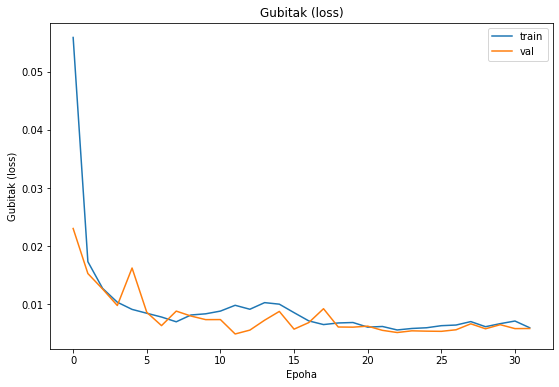

In [ ]:
show_loss(fitted_model3)

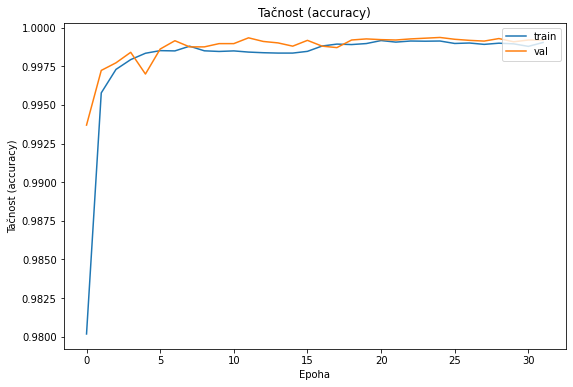

In [ ]:
show_acc(fitted_model3)

#### Testiranje modela

In [ ]:
#TEST
eval_result2 = smote_ruc_model.evaluate(x_test, y_test)
print("[loss tp fp tn fn accuracy precision recall auc prc]:", eval_result)

2222/2222 [==============================] - 11s 5ms/step - loss: 0.0061 - tp: 114.0000 - fp: 47.0000 - tn: 70906.0000 - fn: 17.0000 - accuracy: 0.9991 - precision: 0.7081 - recall: 0.8702 - auc: 0.9348
[loss tp fp tn fn accuracy precision recall auc prc]: [0.004489912185817957, 112.0, 26.0, 70927.0, 19.0, 0.9993669390678406, 0.8115941882133484, 0.8549618124961853, 0.9387764930725098]


556/556 [==============================] - 1s 2ms/step


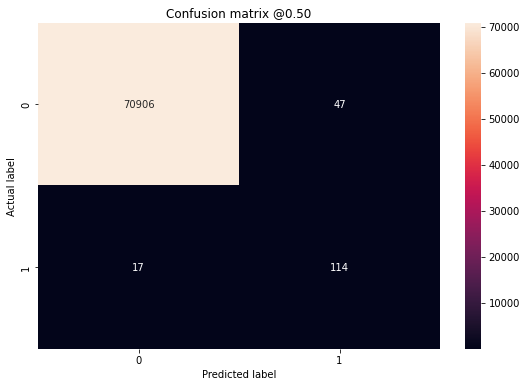

In [ ]:
test_predictions2 = smote_ruc_model.predict(x_test, batch_size=128)
plot_cm(y_test, test_predictions2)

# Random Forest Klasifikator

#### Definisanje modela

In [ ]:
randomForestModel = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

### Oversemplirani dataset

#### Treniranje modela

In [ ]:
rf_fit1 = randomForestModel.fit(x_train_smote, y_train_smote.values)

RandomForestClassifier(n_jobs=4, random_state=2022, verbose=False)

#### Predikcija modela

In [ ]:
rfp1 = rf_fit1.predict(x_val)

In [ ]:
rfp2 = rf_fit1.predict(x_test)

#### AUC

In [ ]:
roc_auc_score(y_val, rfp1)

0.8802464615070114

In [ ]:
roc_auc_score(y_test, rfp2)

0.900728124186713

#### Konfuzijska matrica



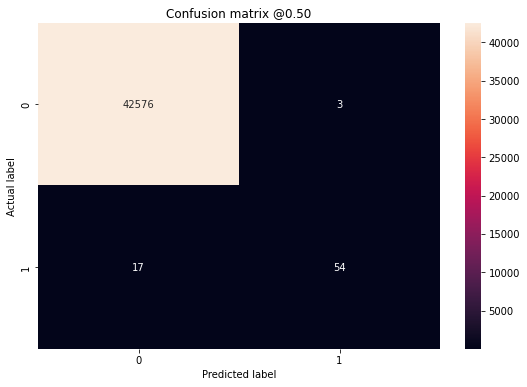

In [ ]:
plot_cm(y_val, rfp1)

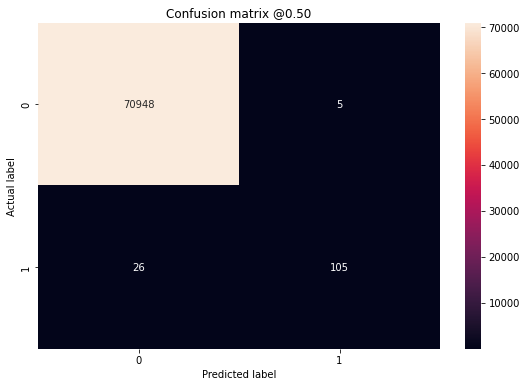

In [ ]:
plot_cm(y_test, rfp2)

ROC_AUC Score :  88.02%


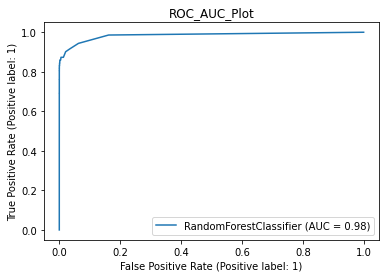

In [ ]:
print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_val,rfp1)))
plot_roc_curve(rf_fit1, x_val,y_val)
plt.title('ROC_AUC_Plot')
plt.show()

ROC_AUC Score :  90.07%


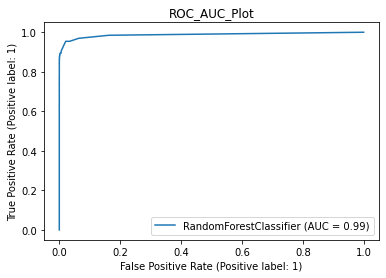

In [ ]:
print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,rfp2)))
plot_roc_curve(rf_fit1, x_test,y_test)
plt.title('ROC_AUC_Plot')
plt.show()

### RUC + Oversemplirani dataset


#### Treniranje modela


In [ ]:
rf_fit2 = randomForestModel.fit(x_train_smote_ruc, y_train_smote_ruc.values)

RandomForestClassifier(n_jobs=4, random_state=2022, verbose=False)

#### Predikcija modela

In [ ]:
rfp3 = rf_fit2.predict(x_val)

In [ ]:
rfp4 = rf_fit2.predict(x_test)

#### AUC


In [ ]:
roc_auc_score(y_val, rfp3)

0.8943192256713204

In [ ]:
roc_auc_score(y_test, rfp4)

0.9236006998719614

#### Konfuzijska matrica

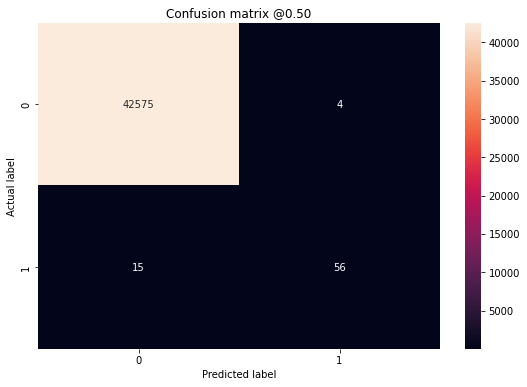

In [ ]:
plot_cm(y_val, rfp3)

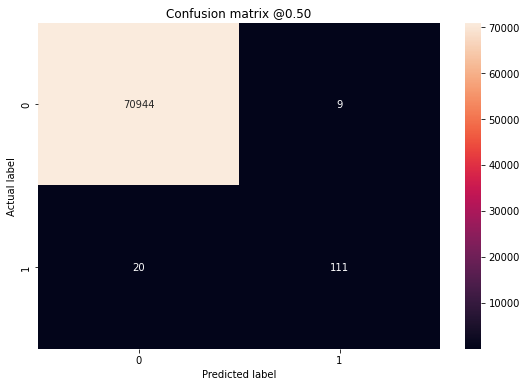

In [ ]:
plot_cm(y_test, rfp4)

ROC_AUC Score :  89.43%


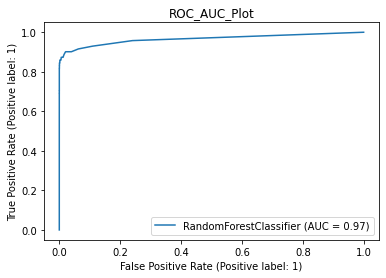

In [ ]:
print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_val,rfp3)))
plot_roc_curve(rf_fit2, x_val,y_val)
plt.title('ROC_AUC_Plot')
plt.show()

ROC_AUC Score :  92.36%


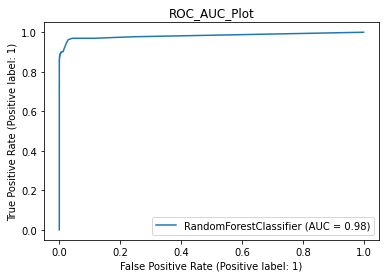

In [ ]:
print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,rfp4)))
plot_roc_curve(rf_fit2, x_test,y_test)
plt.title('ROC_AUC_Plot')
plt.show()

# Logistička regresija

#### Definisanje modela

In [ ]:
classifier_lr = LogisticRegression(random_state = 0,C=10,penalty= 'l2') 

#### Definisanje funkcije za treniranje i evaluaciju modela

In [ ]:
def model(classifier,x_train,y_train,x_test,y_test):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    plot_roc_curve(classifier, x_test,y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

### Oversemplirani dataset


#### Treniranje i predikcija modela

Cross Validation Score :  98.78%
ROC_AUC Score :  95.33%


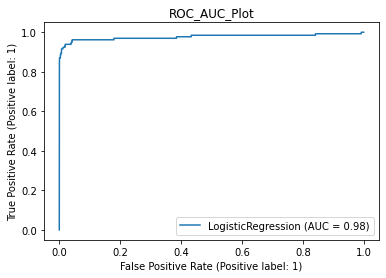

Cross Validation Score :  98.78%
ROC_AUC Score :  92.83%


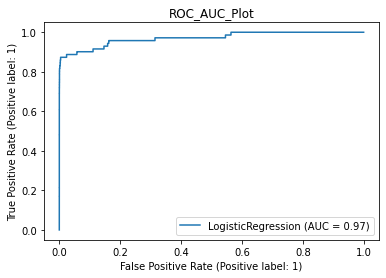

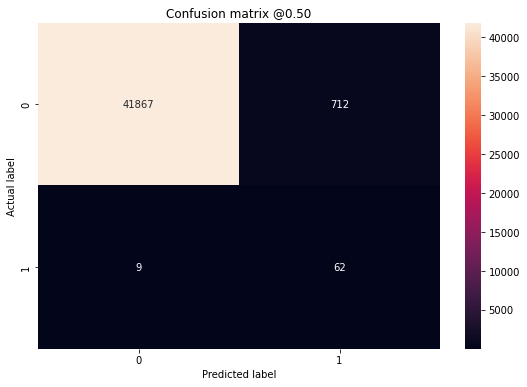

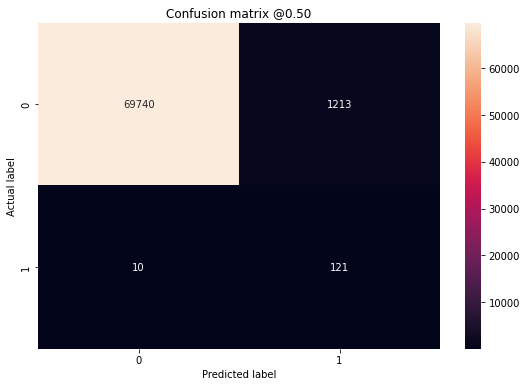

In [ ]:
model(classifier_lr,x_train_smote,y_train_smote,x_test,y_test)

model(classifier_lr,x_train_smote,y_train_smote,x_val,y_val)

lgp1 = classifier_lr.predict(x_val)
lgp2 = classifier_lr.predict(x_test)

plot_cm(y_val, lgp1)
plot_cm(y_test, lgp2)

### RUC + Oversemplirani dataset

#### Treniranje i predikcija modela

Cross Validation Score :  98.85%
ROC_AUC Score :  95.48%


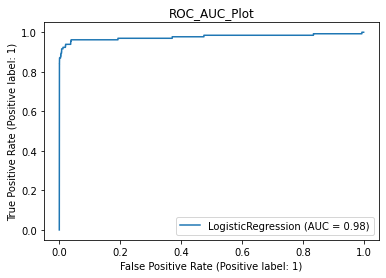

Cross Validation Score :  98.85%
ROC_AUC Score :  92.93%


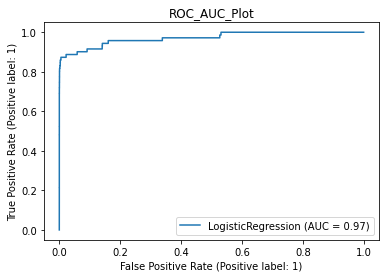

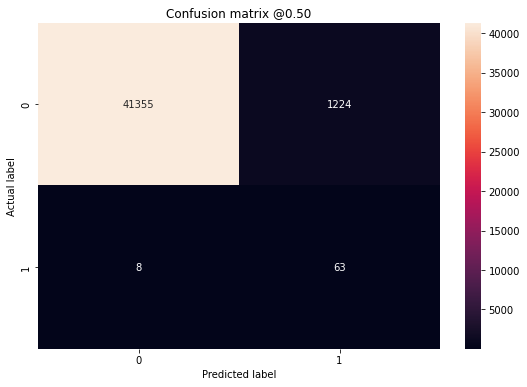

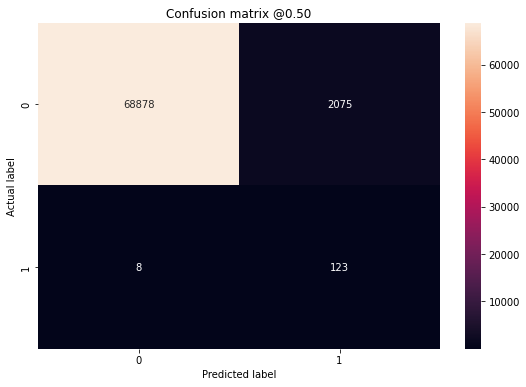

In [ ]:
model(classifier_lr,x_train_smote_ruc,y_train_smote_ruc,x_test,y_test)

model(classifier_lr,x_train_smote_ruc,y_train_smote_ruc,x_val,y_val)

lgp1 = classifier_lr.predict(x_val)
lgp2 = classifier_lr.predict(x_test)

plot_cm(y_val, lgp1)
plot_cm(y_test, lgp2)